In [1]:
%matplotlib inline

import cPickle as pickle
import lda
import matplotlib.pyplot as plt
import numpy as np
import os
from serial_lda_gibbs import LdaSampler
from multicore_lda_gibbs import MulticoreLdaSampler
import time

pickle_filepath = 'baseline_data.pickle'
None


Bad key "axes.spines.right" on line 210 in
//anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "boxplot.flierprops.linewidth" on line 321 in
//anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "contour.corner_mask" on line 306 in
//anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "boxplot.vertical" on line 339 in
//anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get

In [2]:
def load_reuters_dataset():
    if not os.path.exists(pickle_filepath):
        dump_reuters_dataset()
    with open(pickle_filepath, 'r') as rfile:
        X, vocab, titles = pickle.load(rfile)
    return X, vocab, titles

def dump_reuters_dataset():
    X = lda.datasets.load_reuters()
    vocab = lda.datasets.load_reuters_vocab()
    titles = lda.datasets.load_reuters_titles()

    with open(pickle_filepath, 'w') as wfile:
        pickle.dump( (X, vocab, titles), wfile)


In [3]:
def serial_gibbs(X, k, iters=50, log=True):
    sampler = LdaSampler(k)
    start = time.time()
    for it, phi in enumerate(sampler.run(X, maxiter=iters)):
        if log:
            print "Iteration", it
            print "Likelihood", sampler.loglikelihood()
        else:
            i = it
    end = time.time()
    print 'Completed %d iterations in %.3f seconds (serial)' % (iters, end - start)
    return sampler


def multicore_gibbs(X, k, p, iters=50, log=True):
    sampler = MulticoreLdaSampler(k, p)
    start = time.time()
    for it, phi in enumerate(sampler.run(X, maxiter=iters)):
        if log:
            print "Iteration", it
            print "Likelihood", sampler.loglikelihood()
        else:
            i = it
    end = time.time()
    print 'Completed %d iterations in %.3f seconds (P=%d)' % (iters, end - start, p)
    return sampler

In [4]:
#https://archive.ics.uci.edu/ml/datasets/Bag+of+Words
def load(dataset):
    files = {
        'nips': 'docword.nips.txt', 
        'nytimes': 'docwords.nytimes.txt',
    }
    if dataset == 'reuters':
        return load_reuters_dataset()
    elif dataset in files: 
        with open(files[dataset], 'r') as rfile:
            lines = rfile.readlines()
        n_documents = int(lines[0])
        n_words = int(lines[1])
        X = np.zeros((n_documents, n_words))
        data = map(lambda s: map(int, s.split()), lines[3:])
        for doc, word, count in data:
            X[doc-1][word-1] = count
        return X
    else:
        raise Exception ('Dataset %s not found' % dataset)


In [5]:
# data = load_reuters_dataset()[0]
# multicore_gibbs(data, 10, 4,iters=50, log=True)

### serial_gibbs(load('nips'), 10, 16)
times = {}
likelihoods = {}
data = load('nips') #load_reuters_dataset()[0]
k = 20
iters = 10

sampler = serial_gibbs(data, k, iters=50, log=False)
times[0] = np.mean(sampler.sample_times)
likelihoods[0] = sampler.loglikelihood()
for p in [1,2,4,8,16]:
    sampler = multicore_gibbs(data, k, p,iters=50, log=False)
    times[p] = np.mean(sampler.sample_times) + np.mean(sampler.update_times)
    likelihoods[p] = sampler.loglikelihood()


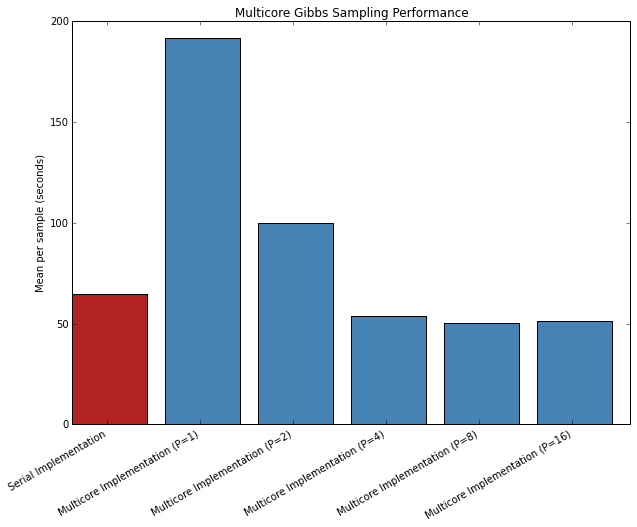

In [7]:
x, y = map(list, zip(*times.items()))
x[0] = 'Serial Implementation'
x[1:] = map(lambda p: 'Multicore Implementation (P=%d)' % p, x[1:])
y = map(abs, y)

fig = plt.figure()
width = .75
ind = np.arange(len(y))
plt.bar(ind[0], y[0], color='firebrick')
plt.bar(ind[1:], y[1:], color='steelblue')

plt.xticks(ind + width / 2, x)
plt.title('Multicore Gibbs Sampling Performance')
plt.ylabel('Mean per sample (seconds)')
fig.autofmt_xdate()
fig.set_size_inches(10, 8)

plt.show()

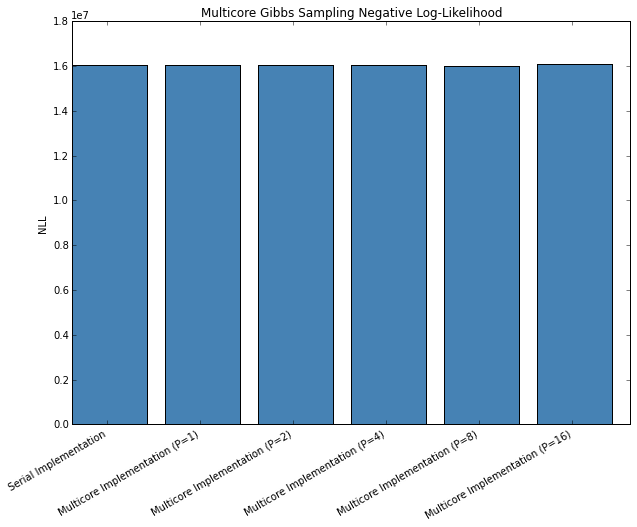

In [8]:
x, y = map(list, zip(*likelihoods.items()))
x[0] = 'Serial Implementation'
x[1:] = map(lambda p: 'Multicore Implementation (P=%d)' % p, x[1:])
y = map(abs, y)

fig = plt.figure()
width = .75
ind = np.arange(len(y))
plt.bar(ind, y, color='steelblue')

plt.xticks(ind + width / 2, x)
plt.title('Multicore Gibbs Sampling Negative Log-Likelihood')
plt.ylabel('NLL')
fig.autofmt_xdate()
fig.set_size_inches(10, 8)

plt.show()

In [9]:
for p, t in times.items():
    print p, abs(t), likelihoods[p]

0 64.8628925943 -16030419.5681
1 191.878400145 -16038560.3105
2 99.7045197487 -16035880.7056
4 53.9036721992 -16056161.6568
8 50.1141946554 -16016469.2268
16 51.3417273712 -16098083.2043
